# LSTM and GRU Models (Core)
- **David Atkins**

### Vectorization Layer

#### Imports

In [34]:
import tensorflow as tf
import numpy as np

# Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)

# Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler

#### Data Prep

In [4]:
# Load Data from your path
df = pd.read_csv("data/spooky.csv", index_col = 'id')
df.head()

,text,author
id,,
id26305,"This process, however, afforded me no means of...",EAP
id17569,It never once occurred to me that the fumbling...,HPL
id11008,"In his left hand was a gold snuff box, from wh...",EAP
id27763,How lovely is spring As we looked from Windsor...,MWS
id12958,"Finding nothing else, not even gold, the Super...",HPL


In [6]:
df['sequence_length'] =df['text'].map( lambda x: len(x.split(" ")))
df.head()

,text,author,sequence_length
id,,,
id26305,"This process, however, afforded me no means of...",EAP,41
id17569,It never once occurred to me that the fumbling...,HPL,14
id11008,"In his left hand was a gold snuff box, from wh...",EAP,36
id27763,How lovely is spring As we looked from Windsor...,MWS,34
id12958,"Finding nothing else, not even gold, the Super...",HPL,27


In [7]:
df['sequence_length'].describe()

count    19579.000000
mean        26.730477
std         19.048353
min          2.000000
25%         15.000000
50%         23.000000
75%         34.000000
max        861.000000
Name: sequence_length, dtype: float64

The range of sequence length is from 2 to 861 terms.

The average length is about 28 words.

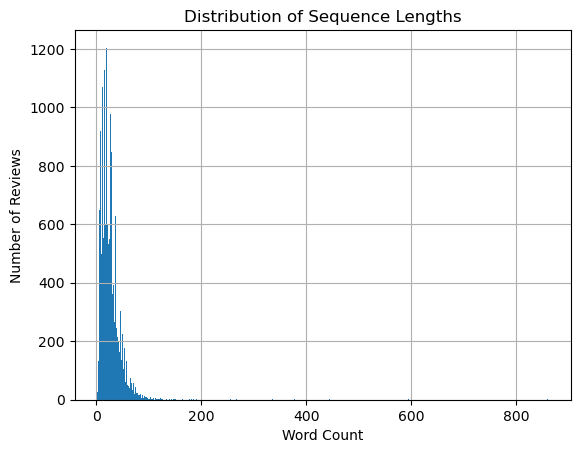

In [8]:
# Make histogram of sequence lengths
ax = df['sequence_length'].hist(bins = 'auto')
ax.set_xlabel('Word Count')
ax.set_ylabel('Number of Reviews')
ax.set_title('Distribution of Sequence Lengths');

In [9]:
df['author'].value_counts(normalize = True)

EAP    0.403494
MWS    0.308698
HPL    0.287808
Name: author, dtype: float64

In [10]:
# Use RUS to reduce n to match minority group
sampler = RandomUnderSampler(random_state=42)
df,  _ = sampler.fit_resample(df, df['author'])
df['author'].value_counts()

EAP    5635
HPL    5635
MWS    5635
Name: author, dtype: int64

In [11]:
# Crate a map for targets
target_map = {'EAP':0,
             'HPL':1,
             'MWS':2}
y = df['author'].map(target_map)
y

id
id22483    0
id18809    0
id16322    0
id13423    0
id09553    0
          ..
id22356    2
id11504    2
id00149    2
id16796    2
id23776    2
Name: author, Length: 16905, dtype: int64

In [12]:
# X and y
X = df['text'].values
X

array(['He then asked me, suddenly, if I had observed any thing peculiar at the scene of the atrocity.',
       'Through the exertions of Beauvais, the matter was industriously hushed up, as far as possible; and several days had elapsed before any public emotion resulted.',
       'The cold was intense, and obliged me to wrap up closely in an overcoat.',
       ...,
       'What I ask of you is reasonable and moderate; I demand a creature of another sex, but as hideous as myself; the gratification is small, but it is all that I can receive, and it shall content me.',
       'The birth of her daughter, embryo copy of her Raymond, filled up the measure of her content, and produced a sacred and indissoluble tie between them.',
       "I heard my sister's sobs, and thought, happy are women who can weep, and in a passionate caress disburthen the oppression of their feelings; shame and habitual restraint hold back a man."],
      dtype=object)

In [13]:
y.value_counts(normalize = True)

0    0.333333
1    0.333333
2    0.333333
Name: author, dtype: float64

In [14]:
classes = y.unique()
classes

array([0, 1, 2], dtype=int64)

In [15]:
# Convert to Dataset Object
ds = tf.data.Dataset.from_tensor_slices((X, y))

# Shuffle dataset
ds = ds.shuffle(buffer_size=len(ds),reshuffle_each_iteration=False) 

In [16]:
# Set the ratio of the train, validation, test split
split_train = .7
split_val =  .2
split_test =  1 -( split_train + split_val )

# Calculate the number of samples for training and validation data 
n_train_samples =  int(len(ds) * split_train)
n_val_samples = int(len(ds) * split_val)
n_test_samples = len(ds) -(n_train_samples + n_val_samples)

# Set the batch size
BATCH_SIZE =32


import math
# math.ceil will round up
# How many batches? 
n_train_batches = math.ceil(n_train_samples/BATCH_SIZE)
n_val_batches = math.ceil(n_val_samples/BATCH_SIZE)
n_test_batches = math.ceil(n_test_samples/BATCH_SIZE)

print(f"    - train:\t{n_train_samples} samples \t({n_train_batches} batches)")
print(f"    - val:  \t{n_val_samples} samples \t({n_val_batches} batches)")
print(f"    - test: \t{n_test_samples} samples \t({n_test_batches} batches)")

    - train:	11833 samples 	(370 batches)
    - val:  	3381 samples 	(106 batches)
    - test: 	1691 samples 	(53 batches)


In [17]:
# Use take and skip to define each set
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)

# Skip over the training batches and take the validation batches
val_ds = ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)

# Skipver the train and validation batches, the remaining are the test batches
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)

In [18]:
# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')

 There are 370 training batches.
 There are 106 validation batches.
 There are 53 testing batches.


#### Text Vectorization

In [19]:
SEQUENCE_LENGTH = 100
# Create text Vectorization layer
sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)

In [20]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)

# Preview the text
ds_texts.take(1).get_single_element()


<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'And this was in truth the Death of which these bystanders spoke reverently, in low whispers you, sweet Una, gaspingly, with loud cries.',
       b'Had my eyes deceived me?',
       b"For some distance the line kept on along the gorge's brink, but at length I reached the long covered bridge where it crossed the chasm at a dizzy height.",
       b'The two forces mingling, unarmed and hand in hand, talking only how each might assist the other, the adversaries conjoined; each repenting, the one side their former cruelties, the other their late violence, they obeyed the orders of the General to proceed towards London.',
       b'I have already put off the carelessness of childhood, the unlined brow, and springy gait of early years, that they may adorn thee.',
       b'Idleness had ever been irksome to me, and now that I wished to fly from reflection, and hated my former studies, I felt great relief in being the fellow pupil with my frie

In [21]:
# Train (adapt on training text data))
sequence_vectorizer.adapt(ds_texts)
sequence_vectorizer.vocabulary_size()

20976

In [22]:
# Programmatically define size of vocab from vectorization layer
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
VOCAB_SIZE

20976

In [23]:
# Getting list of vocab
vocab = sequence_vectorizer.get_vocabulary()
int_to_str = {idx: word for idx, word in enumerate(vocab)}
int_to_str

{0: '',
 1: '[UNK]',
 2: 'the',
 3: 'of',
 4: 'and',
 5: 'to',
 6: 'i',
 7: 'a',
 8: 'in',
 9: 'was',
 10: 'that',
 11: 'my',
 12: 'it',
 13: 'he',
 14: 'had',
 15: 'with',
 16: 'his',
 17: 'as',
 18: 'for',
 19: 'but',
 20: 'which',
 21: 'not',
 22: 'me',
 23: 'at',
 24: 'from',
 25: 'by',
 26: 'on',
 27: 'this',
 28: 'is',
 29: 'her',
 30: 'be',
 31: 'were',
 32: 'have',
 33: 'you',
 34: 'all',
 35: 'an',
 36: 'we',
 37: 'or',
 38: 'no',
 39: 'when',
 40: 'him',
 41: 'one',
 42: 'so',
 43: 'they',
 44: 'been',
 45: 'could',
 46: 'would',
 47: 'she',
 48: 'there',
 49: 'upon',
 50: 'more',
 51: 'its',
 52: 'their',
 53: 'now',
 54: 'what',
 55: 'some',
 56: 'our',
 57: 'into',
 58: 'if',
 59: 'them',
 60: 'who',
 61: 'are',
 62: 'will',
 63: 'than',
 64: 'then',
 65: 'only',
 66: 'very',
 67: 'up',
 68: 'before',
 69: 'man',
 70: 'about',
 71: 'even',
 72: 'these',
 73: 'out',
 74: 'yet',
 75: 'your',
 76: 'time',
 77: 'did',
 78: 'any',
 79: 'old',
 80: 'said',
 81: 'might',
 82: 'li

In [24]:
# What term corresponds to 1000?
int_to_str[1000]

'occasion'

In [25]:
# Obtain the sequence of sample text with the sequence_vectorizer
sequence= sequence_vectorizer(['Text Vectorization is an essential tool for converting text into a format that machine learning models can use.'])
sequence

<tf.Tensor: shape=(1, 100), dtype=int64, numpy=
array([[ 6345,     1,    28,    35,  6996, 13401,    18,     1,  6345,
           57,     7,     1,    10,   833,  3862, 16160,   122,   521,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int64)>

### LSTM

In [32]:
%load_ext autoreload
%autoreload 2

import functions as fn

In [38]:
# Define sequence length as a variable for future use
SEQUENCE_LENGTH = 400
# Define vectorizer layer. Use the custom function to build and fit the vectorizer before using it in model
sequence_vectorizer, vocab_lookup = fn.make_text_vectorization_layer(train_ds, output_mode='int', output_sequence_length = SEQUENCE_LENGTH, verbose=True)

Cause: could not parse the source code of <function make_text_vectorization_layer.<locals>.<lambda> at 0x0000024A57544550>: no matching AST found among candidates:
# coding=utf-8
lambda x, y: x
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function make_text_vectorization_layer.<locals>.<lambda> at 0x0000024A57544550>: no matching AST found among candidates:
# coding=utf-8
lambda x, y: x
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

tf.keras.layers.TextVectorization(
{   'batch_input_shape': (None,),
    'dtype': 'string',
    'encoding': 'utf-8',
    'idf_weights': None,
    'max_tokens': None,
    'name': 'text_vectorization_3',
    'ngrams': None,
    'output_mode': 'int',
    'output_sequence_length': 400,
    'pad_to_max_tokens': False,
    'ragged': False,
    'sparse': False,
    'split': 'whitespace',
    'standardize': 'lower_and_strip_pun

In [40]:
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
VOCAB_SIZE

20976

In [43]:
# Define a function for building an LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers
def build_lstm_model(text_vectorization_layer):
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    lstm_model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add *new* LSTM layer
    lstm_model.add(layers.LSTM(128))
    # Add output layer
    lstm_model.add(layers.Dense(len(classes), activation='softmax'))
 
    # Compile the model
    lstm_model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .01), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    lstm_model.summary()
    return lstm_model

In [44]:
# Include callbacks
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

In [46]:
# defining embedding layer
EMBED_DIM = 150

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, 400)              0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 400, 150)          3146400   
                                                                 
 lstm (LSTM)                 (None, 128)               142848    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 3,289,635
Trainable params: 3,289,635
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
370/370 [==============================] - 114s 304ms/step - loss: 1.1179 - accuracy: 0.3331 - val_lo

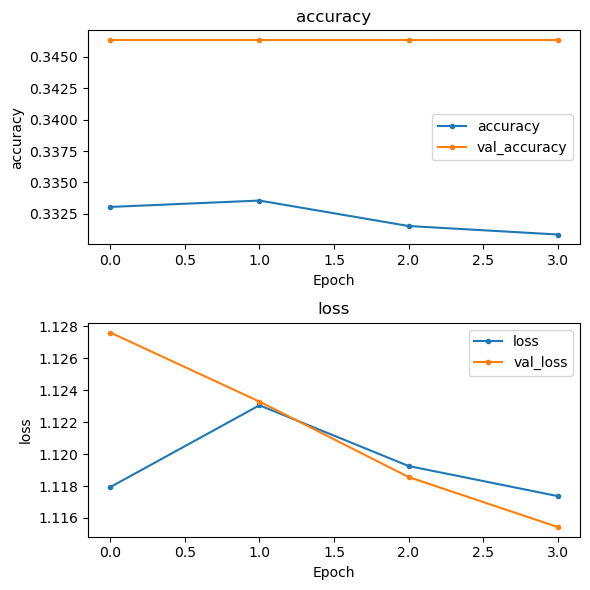


- Evaluating Network...


C:\Users\gondr\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gondr\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gondr\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.33      1.00      0.50      3906
           1       0.00      0.00      0.00      3952
           2       1.00      0.00      0.00      3975

    accuracy                           0.33     11833
   macro avg       0.44      0.33      0.17     11833
weighted avg       0.44      0.33      0.16     11833



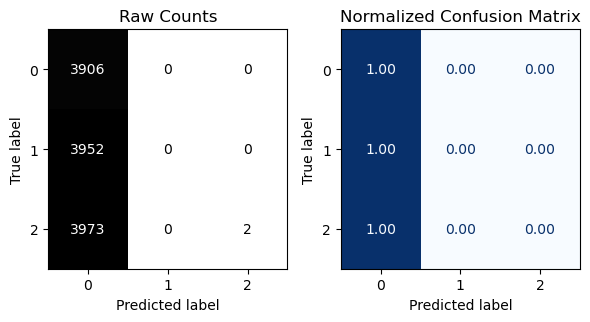


- Evaluating Training Data:
  2/370 [..............................] - ETA: 27s - loss: 1.1333 - accuracy: 0.2812

C:\Users\gondr\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gondr\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gondr\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


370/370 [==============================] - 28s 74ms/step - loss: 1.1199 - accuracy: 0.3303
{'loss': 1.1199005842208862, 'accuracy': 0.33026280999183655}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.33      1.00      0.50       559
           1       0.00      0.00      0.00       560
           2       0.00      0.00      0.00       572

    accuracy                           0.33      1691
   macro avg       0.11      0.33      0.17      1691
weighted avg       0.11      0.33      0.16      1691



C:\Users\gondr\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gondr\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gondr\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


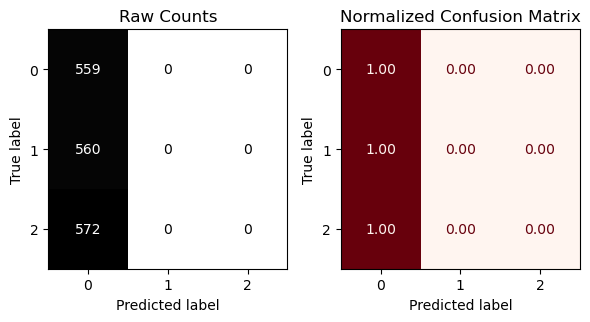


- Evaluating Test Data:
 2/53 [>.............................] - ETA: 3s - loss: 1.0967 - accuracy: 0.3750

C:\Users\gondr\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gondr\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gondr\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


53/53 [==============================] - 4s 74ms/step - loss: 1.1184 - accuracy: 0.3306
{'loss': 1.1183526515960693, 'accuracy': 0.3305736184120178}


In [47]:
# Build the lstm model and specify the vectorizer
lstm_model = build_lstm_model(sequence_vectorizer)
# Defien number of epocs
EPOCHS = 30
# Fit the model
history = lstm_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
# Obtain the results
results = fn.evaluate_classification_network(
    lstm_model, X_train=train_ds, 
    X_test=test_ds, history=history
);

### GRU

In [48]:
# Confirming relevant values
print(f' VOCAB_SIZE: {VOCAB_SIZE}')
print(f' EMBED_DIM: {EMBED_DIM}')
print(f' SEQUENCE_LENGTH: {SEQUENCE_LENGTH}')

 VOCAB_SIZE: 20976
 EMBED_DIM: 150
 SEQUENCE_LENGTH: 400


In [49]:
def build_gru_model(text_vectorization_layer):
                
    gru_model = Sequential([
        text_vectorization_layer,
        tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)])
    # Add GRU layer *new*
    gru_model.add(layers.GRU(128, return_sequences = True))   
    gru_model.add(layers.GlobalMaxPooling1D())
    # Output layer
    gru_model.add(layers.Dense(len(classes), 
                              activation='softmax'))
        
    optimizer = optimizers.legacy.Adam()
    gru_model.compile(optimizer=optimizer,  
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    gru_model.summary()
    return gru_model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, 400)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 400, 150)          3146400   
                                                                 
 gru (GRU)                   (None, 400, 128)          107520    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 3,254,307
Trainable params: 3,254,307
No

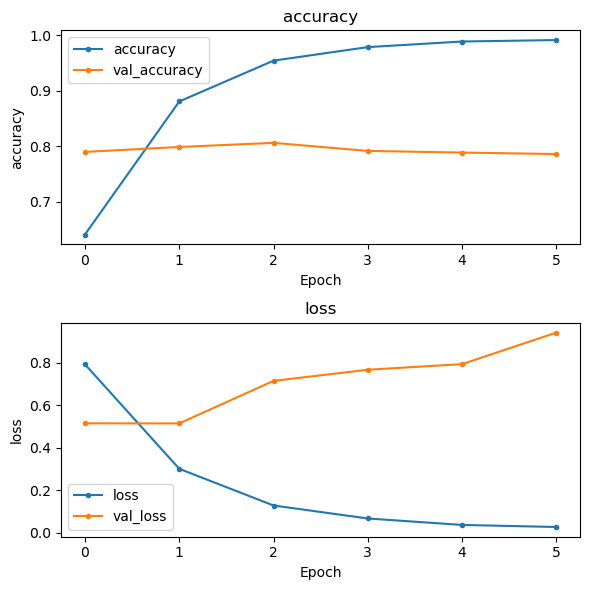


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3906
           1       1.00      0.99      0.99      3952
           2       0.99      0.99      0.99      3975

    accuracy                           0.99     11833
   macro avg       0.99      0.99      0.99     11833
weighted avg       0.99      0.99      0.99     11833



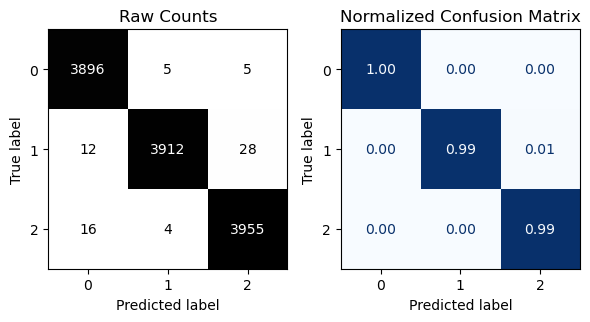


- Evaluating Training Data:
370/370 [==============================] - 23s 62ms/step - loss: 0.0182 - accuracy: 0.9941
{'loss': 0.018235167488455772, 'accuracy': 0.994084358215332}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.81      0.78       559
           1       0.83      0.76      0.79       560
           2       0.81      0.83      0.82       572

    accuracy                           0.80      1691
   macro avg       0.80      0.80      0.80      1691
weighted avg       0.80      0.80      0.80      1691



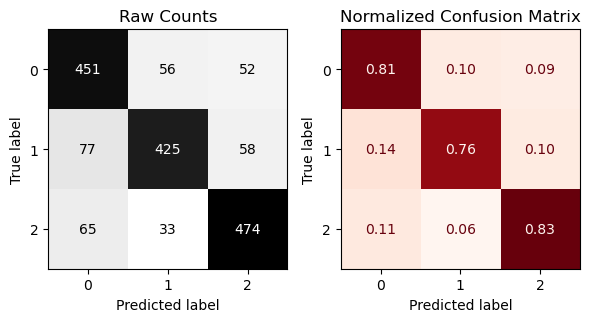


- Evaluating Test Data:
53/53 [==============================] - 3s 61ms/step - loss: 0.9212 - accuracy: 0.7983
{'loss': 0.9212335348129272, 'accuracy': 0.7983441948890686}


In [50]:
# Build the model
model = build_gru_model(sequence_vectorizer)
# Fit the model
EPOCHS = 30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
# Evaluate the model
results = fn.evaluate_classification_network(
    model, X_train=train_ds, 
    X_test=test_ds, history=history);